# AOS_singleAmpSep

# Star Separation Test on a single Amplifier

### Motivation 

A notebook to test the performance of comcam close loop (estimation of Zernike polynomials from the Wavefront Estimation Calculation pipeline) as the simulated stars are brought closer together,  possibly bringing us to the regime of overlapping donuts. We ensure that stars are simulated on a single amplifier, to avoid positioning on CCD edges where some non-uniformity in donut image could be due to the instrument signature removal (ISR) process, which is in constant improvement.

### Performance Metric 

The RMS value between OPD results and the Zernike polynomials given by ts_wep output.

### Test Data 

Created on UW *epyc*, in `epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/`. 

The exact steps:

    cd /epyc/users/suberlak/Commissioning/aos/
    source setup_aos_2020_15.sh 
    cd  ts_phosim/notebooks/analysis_scripts/
    python runSingleAmpStarSep.py


In [2]:
#Note: can display all arguments, and even run from the ipython notebook,.
#but I find that then not all the console output gets printed here
!python ../analysis_scripts/runSingleAmpStarSep.py -h

usage: runSingleAmpStarSep.py [-h] [--testLabel TESTLABEL] [--magVal MAGVAL]
                              [--numPro NUMPRO] [--iterNum ITERNUM]
                              [--numFields NUMFIELDS] [--numStars NUMSTARS]
                              [--opd] [--flats] [--defocalImg]
                              [--doDeblending] [--postageImg]
                              [--topDir TOPDIR] [--expDir EXPDIR]
                              [--copyDir COPYDIR]

Run ComCam AOS closed loop for varying star separation

optional arguments:
  -h, --help            show this help message and exit
  --testLabel TESTLABEL
                        test label
  --magVal MAGVAL       magnitude for simulated stars
  --numPro NUMPRO       number of processors setting in phosimCmptSetting.yaml
  --iterNum ITERNUM     number of iterations
  --numFields NUMFIELDS
                        number of CCDs, 3 is the minimum for ts_wep
  --numStars NUMSTARS   number of stars to simulate
  --opd                 

In [1]:
# Note: one could run the entire thing from this notebook and catch the 
# console output with subprocess:  
import subprocess
cmd = ['python','../analysis_scripts/runSingleAmpStarSep.py','-h',]
proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)
output = proc.communicate()[0]
print(output.decode('ascii'))

In [2]:
print(output.decode('ascii'))

usage: runSingleAmpStarSep.py [-h] [--testLabel TESTLABEL] [--magVal MAGVAL]
                              [--numPro NUMPRO] [--iterNum ITERNUM]
                              [--numFields NUMFIELDS] [--numStars NUMSTARS]
                              [--opd] [--flats] [--defocalImg]
                              [--doDeblending] [--postageImg]
                              [--topDir TOPDIR] [--expDir EXPDIR]
                              [--copyDir COPYDIR]

Run ComCam AOS closed loop for varying star separation

optional arguments:
  -h, --help            show this help message and exit
  --testLabel TESTLABEL
                        test label
  --magVal MAGVAL       magnitude for simulated stars
  --numPro NUMPRO       number of processors setting in phosimCmptSetting.yaml
  --iterNum ITERNUM     number of iterations
  --numFields NUMFIELDS
                        number of CCDs, 3 is the minimum for ts_wep
  --numStars NUMSTARS   number of stars to simulate
  --opd                 

### Results

In [1]:
import os
from astropy.table import Table
import numpy as np

# IMPORT CUSTOM FUNCTIONS 
import sys
sys.path.append('../analysis_tools/')
from calcMetrics import calcMetrics
import analysisTools as at 

# IMPORT LSST MODULES 
from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.Utility import FilterType

from lsst.ts.ofc.Utility import InstName
from lsst.ts.ofc.ctrlIntf.OFCCalculationFactory import OFCCalculationFactory

from lsst.ts.phosim.SkySim import SkySim
from lsst.ts.phosim.OpdMetrology import OpdMetrology
from lsst.ts.phosim.Utility import getAoclcOutputPath, getConfigDir

# IMPORT PLOTTING MODULES
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [2]:
# setup the location of analysis files ... 
baseDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
topDir = 'results_after_centroid_update'
resDir = 'singleAmpSepNew'


Illustrate what we are doing (running the AOS loop 10 times, each time simulating two stars per CCD, with 9 ComCam CCDs) by plotting full image of several CCDs : 

In [3]:
import imp
imp.reload(at)

<module 'analysisTools' from '../analysis_tools/analysisTools.py'>

In [4]:
sep=10
data_dir = os.path.join(baseDir, topDir,resDir, 'sep_%d' % sep)
image = at.readPostISRImage(data_dir, focalType = 'extra', raft = 'R22', detector = 'S00',)
centroid, centFlag = at.readCentroidInfo(data_dir, focalType='extra', raft='R22',detector='S00')

data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Done

Reading centroid files from /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_10/iter0/img/extra
The following files are available:
centroid_lsst_e_9006001_f1_R22_S01_E000.txt
centroid_lsst_e_9006001_f1_R22_S11_E000.txt
centroid_lsst_e_9006001_f1_R22_S02_E000.txt
centroid_lsst_e_9006001_f1_R22_S22_E000.txt
centroid_lsst_e_9006001_f1_R22_S10_E000.txt
centroid_lsst_e_9006001_f1_R22_S00_E000.txt
centroid_lsst_e_9006001_f1_R22_S21_E000.txt
centroid_lsst_e_9006001_f1_R22_S20_E000.txt
centroid_lsst_e_9006001_f1_R22_S12_E000.txt
Using centroid_lsst_e_9006001_f1_R22_S00_E000.txt 


Reading info about postage-stamp images from postagedonutStarsExtraIntra.txt


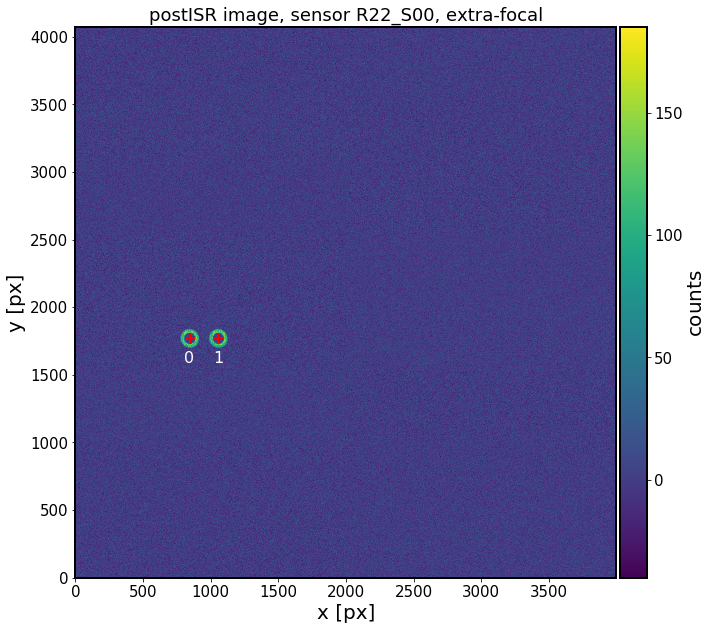

In [7]:
%matplotlib inline
import imp
imp.reload(at)
postage, postFlag =  at.readPostageStars(data_dir)
at.plotImage(image,ax=None, log=False, sensor='R22_S00', focalType='extra',
          postage=postage,postFlag=postFlag, centroid=centFlag, 
          starMarker='redCross',starMarkerArgs=None,
          centMarkerArgs = None,centMarker='redCross')

First, plot root-mean-squared difference between wavefront estimation from `ts_wep`, and the OPD (truth) : 

10
9
8
7
6
5
4
3
2
1


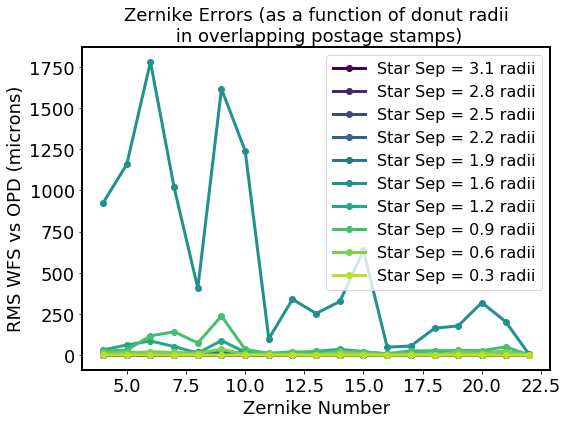

In [9]:

ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

calcMagMetrics = calcMetrics()


sepArr = np.arange(1,11)[::-1]

N = len(sepArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 


for sep in sepArr :
    print(sep)
    data_dir = os.path.join(baseDir, topDir,resDir, 'sep_%d' % sep)
    opdZkFilePath = os.path.join(data_dir,  'iter0/img/', 'opd.zer.sep.%d'%sep)
    wfsZkFilePath = os.path.join(data_dir,  'iter0/img/', 'wfs.zer.sep.%d'%sep)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData
    wfsData = wfsData
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))

fig = plt.figure(figsize=(8,6))

for i in range(len(sepArr)):
    sepInRadii = at.sepInPercToRadii(sepArr[i])
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label='Star Sep = %.1f radii' % sepInRadii,
             color = cmap(colors[i]) )
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors (as a function of donut radii\n in overlapping postage stamps)', size=18)
    
plt.tight_layout()


Let's step through parts:  

1) those stars that are far-away have good recovery of the wavefront: 

10
9
8


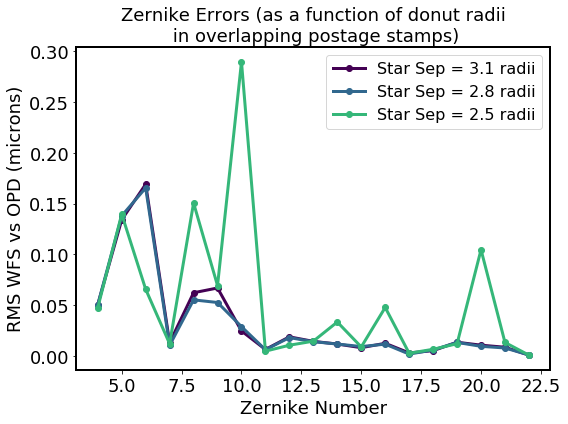

In [11]:

ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

calcMagMetrics = calcMetrics()

sepArr = [10,9,8]

N = len(sepArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 

for sep in sepArr:
    print(sep)
    data_dir = os.path.join(baseDir, topDir,resDir, 'sep_%d' % sep)
    opdZkFilePath = os.path.join(data_dir,  'iter0/img/', 'opd.zer.sep.%d'%sep)
    wfsZkFilePath = os.path.join(data_dir,  'iter0/img/', 'wfs.zer.sep.%d'%sep)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))

fig = plt.figure(figsize=(8,6))

for i in range(len(sepArr)):
    sepInRadii = at.sepInPercToRadii(sepArr[i])
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label='Star Sep = %.1f radii' % sepInRadii,
             color = cmap(colors[i]) )
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors (as a function of donut radii\n in overlapping postage stamps)', size=18)
    
plt.tight_layout()


This picture from https://www.janssenprecisionengineering.com/wp-content/uploads/Zernike_modes_adapted.png illustrates which optical distortions these Zernikes correspond: 
    <img src='Zernike_modes_adapted.png'></img>

Plot wfs error for each star separation as well as postISR image to illustrate, for a particular intra-focal sensor

In [12]:
# Read each figure as a postage stamp, store data to an array 
images = {}
sepArr = np.arange(1,11)[::-1]
for sep in sepArr:
    print(sep)
    data_dir = os.path.join(baseDir, topDir,resDir, 'sep_%d' % sep)
    images[sep] = at.readPostISRImage(data_dir, focalType = 'extra', raft = 'R22',
                     detector = 'S00',)
    

data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Done

data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Done

data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Done



3.103030303030303


../analysis_tools/analysisTools.py:300: RuntimeWarning: invalid value encountered in log10
  img = ax[1].imshow(np.log10(image[ymin:ymax, xmin:xmax]), vmin = 0.01,


2.7927272727272725


../analysis_tools/analysisTools.py:300: RuntimeWarning: invalid value encountered in log10
  img = ax[1].imshow(np.log10(image[ymin:ymax, xmin:xmax]), vmin = 0.01,


2.4824242424242424


../analysis_tools/analysisTools.py:300: RuntimeWarning: invalid value encountered in log10
  img = ax[1].imshow(np.log10(image[ymin:ymax, xmin:xmax]), vmin = 0.01,


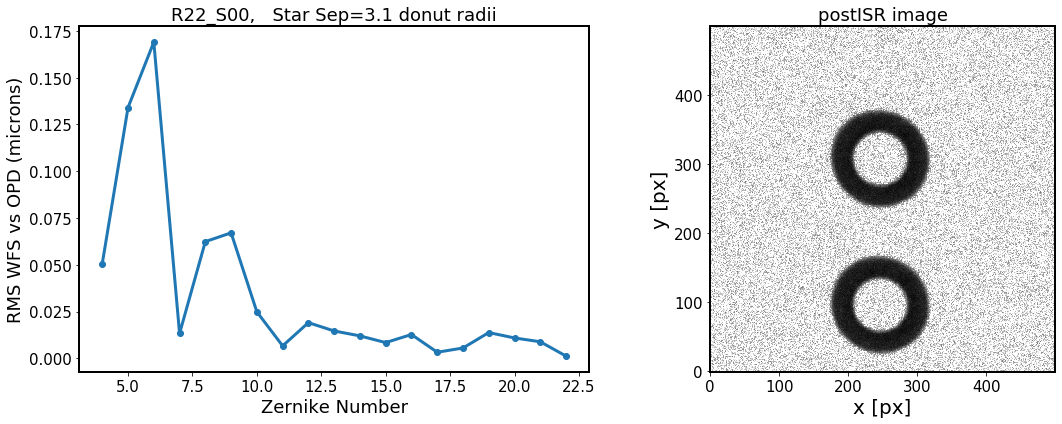

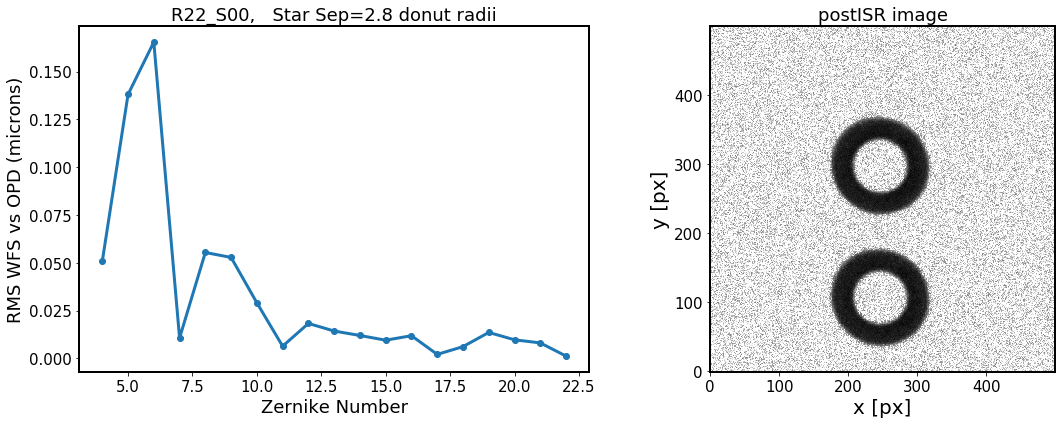

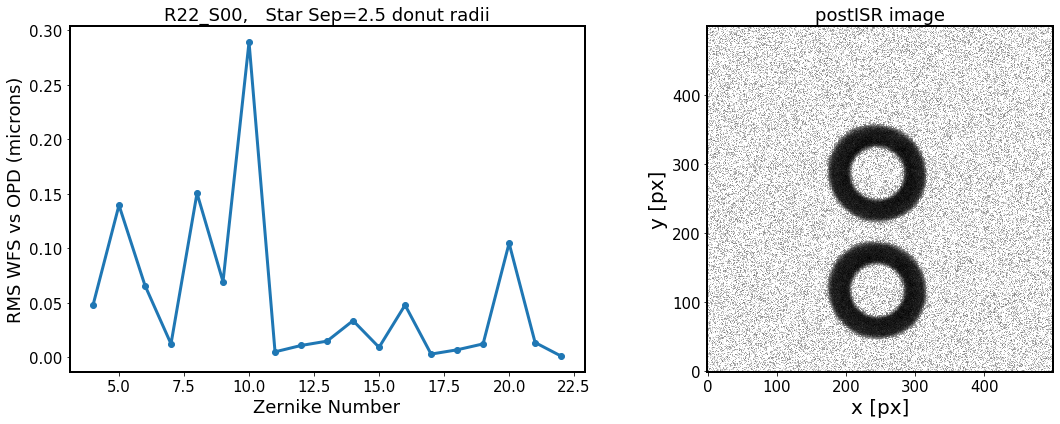

In [13]:
# print Zernikes and image data 

#  plot the Zernikes 
sepArr = np.arange(1,11)[::-1]
for i in range(len(sepArr)):
    
    sepInPerc = sepArr[i]
    rmsErrors = np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i])
    image = images[sepInPerc]
    
    at.plotZernikesAndCCD(image, rmsErrors, sepInPerc , xlims=[1525,2025], ylims=[750,1250],
                      sensor = 'R22_S00')


Plot the postage stamp images at different stages : 

Using postage images from /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_1/postage
Searching in /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_1/postage directory

Available postage stamp images for sensor R22_S02: 

Looking for files that start with "extra_singleSciImg" and contain "R22_S02"...

Found 2 singleSciImg postage stamp images 
['extra_singleSciImg_sensor-R22_S02_star-0_id-4_posX-808_posY-1637.txt', 'extra_singleSciImg_sensor-R22_S02_star-1_id-5_posX-808_posY-1637.txt']

Looking for files that start with "extra_imgDeblend_full" and contain "R22_S02"...

Found 2 imgDeblend_full postage stamp images 
['extra_imgDeblend_full_sensor-R22_S02_star-0_id-4_posX-808_posY-1637.txt', 'extra_imgDeblend_full_sensor-R22_S02_star-1_id-5_posX-808_posY-1637.txt']

Looking for files that start with "extra_imgDeblend_resized" and contain 

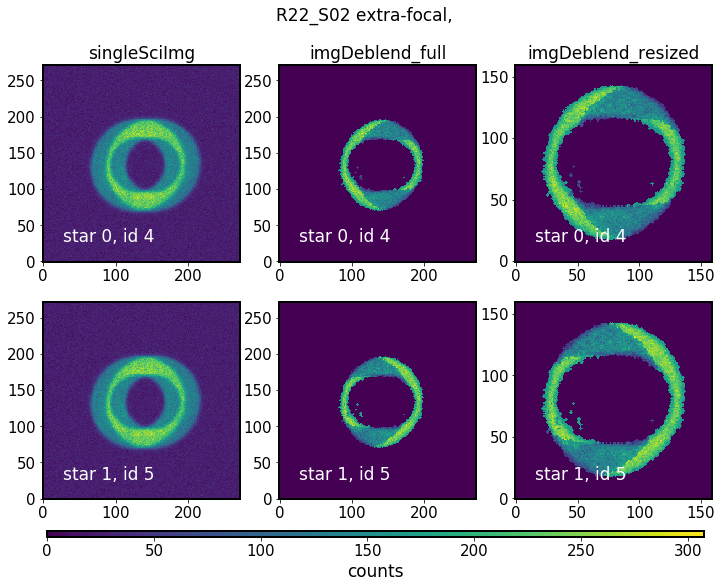

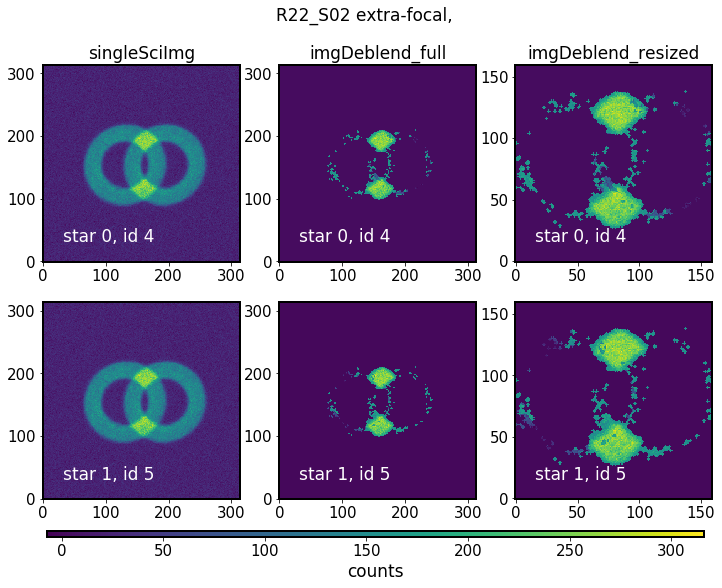

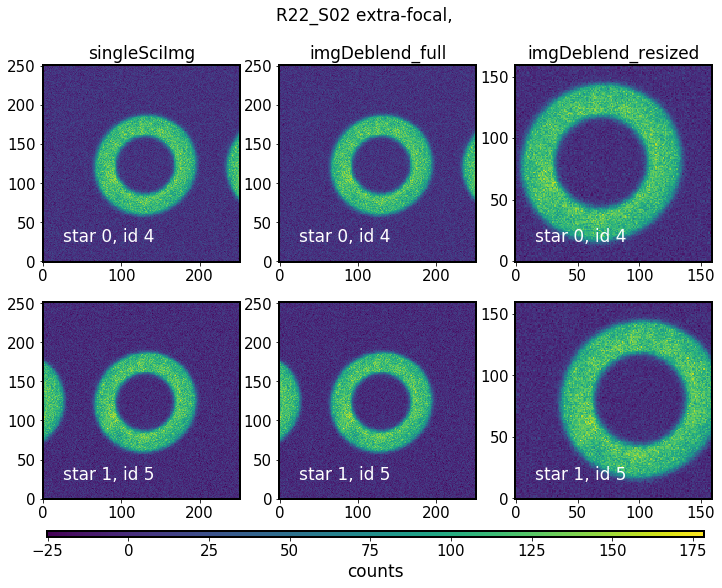

In [14]:
%matplotlib inline
sensor='R22_S02'; focalType='extra';
for sep in [1,3,8]:
    data_dir = os.path.join(baseDir, topDir,resDir, 'sep_%d' % sep)
    at.plotPostageStamps(data_dir, sensor=sensor, focalType=focalType, Nstars=2,
                         sepInPerc=sep)
